In [26]:
import matplotlib
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt

%matplotlib inline

from PIL import Image
from pathlib2 import Path
import cv2
import pandas as pd
import seaborn as sns



In [9]:
original_image_dir = Path('original_images/')
modified_image_dir = Path('modified_images/')

original_image_paths = list(original_image_dir.glob('*.png'))
modified_image_paths = list(modified_image_dir.glob('*.png'))

print 'original {}, modified {}'.format(len(original_image_paths), 
                                        len(modified_image_paths))

original 1788, modified 1788


In [16]:
blah = cv2.imread(str(rotated_image_name))
blah.shape

(357, 500, 3)

Types of transforms

- blur
- rotate
    - all the rotations don't pad the boundary with anything, fit a minimal area rectangle to everything non-black should get them
- color transform (-> gray, -> weird)

preprocessing pipeline
- grayscale (undo color transforms)
- rectify (undo rotations pt 1)
- optionally, rotate right to make landscape
- center crop (by percentage) (undo rotations pt 2)
- blur and downsample to minimal size (determined from corpus)

calculate rmse pairwise across dataset

In [22]:
# image statistics
def image_info(filepath):
    image = cv2.imread(str(filepath))
    height, width, channels = image.shape
    
    return {'filename':str(filepath), 
            'height': height, 
            'width': width,
            'channels': channels}


original_dimensions = pd.DataFrame([image_info(f) for f in original_image_paths])
modified_dimensions = pd.DataFrame([image_info(f) for f in modified_image_paths])

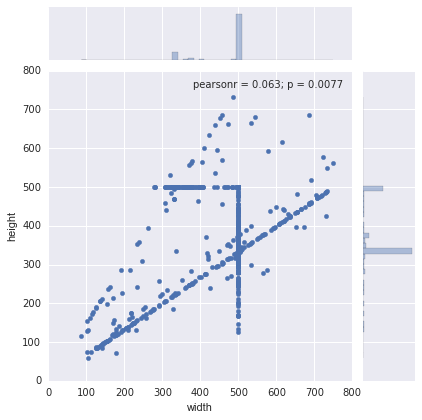

In [28]:
sns.jointplot(data=modified_dimensions, x='width', y='height')

In [29]:
# before we get into this, let's try a perceptual hash


In [17]:
# testing preprocessing pipeline
rotated_image_name = Path('/home/chris/projects/image_match/modified_images/fe6c006d-655b-4f69-b7d8-c8063df3d2d3.png')
gray_image_name = Path('/home/chris/projects/image_match/modified_images/fe984cbe-8906-46eb-b4d2-c6000836fbb2.png')